## Import Lib

In [ ]:
## Data Analysis
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Machine Learning
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost

## Other
import warnings

## Helper Funtion

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 ba 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c 

In [ ]:
warnings.filterwarnings("ignore")

## Read Data

In [ ]:
df = pd.read_csv('QuadData.csv').drop('id',axis=1)

In [ ]:
df_train = df[(~df.Lat.isna()) & (~df.Lng.isna())]
df_test = df[df.Lat.isna()]

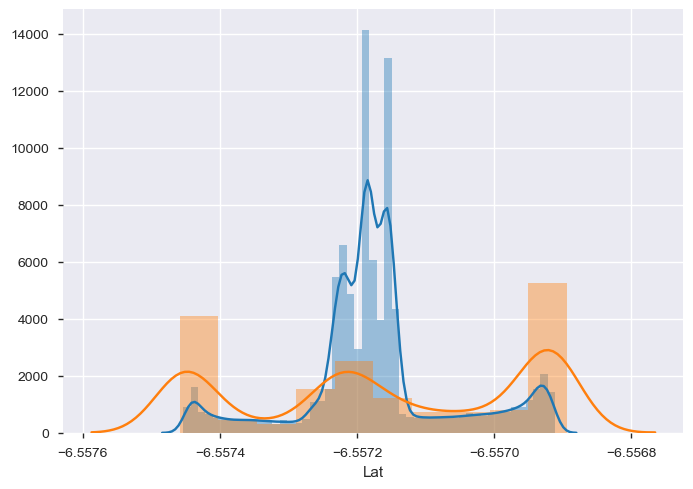

In [ ]:
sns.distplot(df[df['PatternID']==1]['Lat'].dropna())
sns.distplot(df[df['PatternID']==2]['Lat'].dropna())

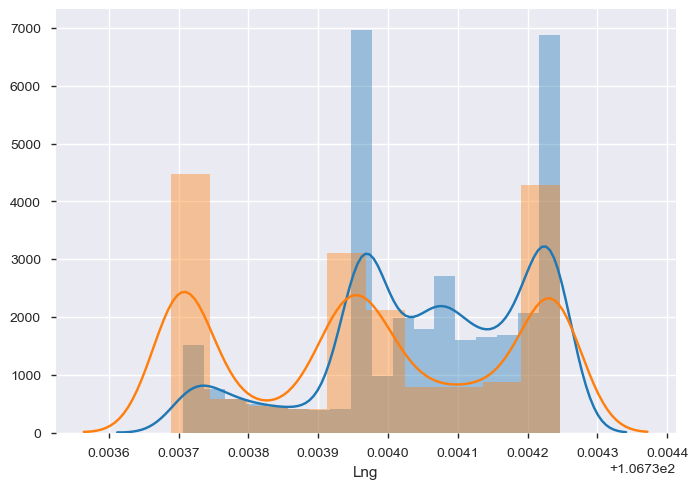

In [ ]:
sns.distplot(df[df['PatternID']==1]['Lng'].dropna())
sns.distplot(df[df['PatternID']==2]['Lng'].dropna())

In [ ]:
df[df['PatternID']==2].DeviceID.value_counts()

F330    4055
F450     821
Name: DeviceID, dtype: int64

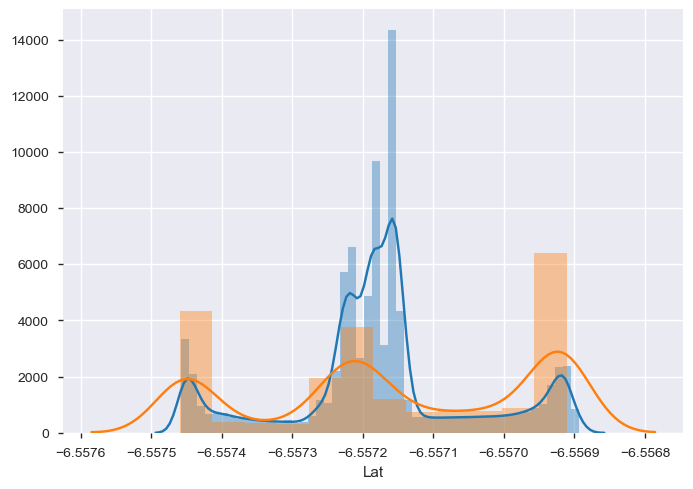

In [ ]:
sns.distplot(df[df['DeviceID']=='F450']['Lat'].dropna())
sns.distplot(df[df['DeviceID']=='F330']['Lat'].dropna())

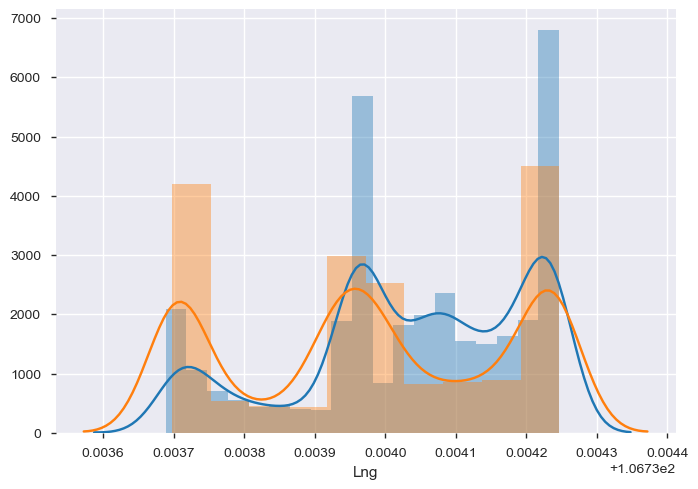

In [ ]:
sns.distplot(df[df['DeviceID']=='F450']['Lng'].dropna())
sns.distplot(df[df['DeviceID']=='F330']['Lng'].dropna())

In [ ]:
diagnosis = pandas_profiling.ProfileReport(df_train)

In [ ]:
diagnosis

Number of variables,93
Number of observations,6440
Total Missing (%),1.1%
Total size in memory,4.6 MiB
Average record size in memory,744.0 B
Numeric,45
Categorical,1
Boolean,2
Date,0
Text (Unique),0
Rejected,45


## Drop all Rejected Column

Drop all column that either have corelation >0.9 or have a constant value

In [ ]:
MOfs = [c for c in df_train.columns if c[:4] == 'MOfs'] ## Constant 0

In [ ]:
dropped_columns = diagnosis.get_rejected_variables().copy() ## More than 0.9 corelation
dropped_columns.extend(MOfs) ## Extend both

In [ ]:
df_train.drop(['SAlt'],axis=1,inplace=True)  ## Constant 0
df_train.drop(['VV'],axis=1,inplace=True) ## COnstant 1
df_train.drop(['DSAlt'],axis=1,inplace=True) ## Constant Null
df_train.drop(['GWk'],axis=1,inplace=True) ## Constant Value
df_train.drop(dropped_columns,axis=1,inplace=True) # Drop All

In [ ]:
df_train.head()

NameError: name 'df_train' is not defined

## Modelling

In [ ]:
xgb_lat = XGBRegressor()
xgb_lon = XGBRegressor()

kf=KFold(10)

In [ ]:
df_train = pd.get_dummies(df_train)

In [ ]:
sc_lat = MinMaxScaler()
sc_lon = MinMaxScaler()

In [ ]:
df_train.head()

,ExpID,PatternID,LineNo_ATT,DesRoll,Roll,DesPitch,Pitch,DesYaw,Yaw,ErrRP,...,MagY,MagZ,MagZ_2,C1,C2,C3,Lat,Lng,DeviceID_F330,DeviceID_F450
0,6,2,14206,-2.52,-0.74,-2.30,-1.55,359.96,2.12,0.10,...,-12,-200,-275,1536,1578,1719,-6.557158,106.733964,0,1
1,6,2,14216,-2.64,0.28,-2.95,-1.02,359.96,359.69,0.12,...,4,-193,-277,1581,1553,1697,-6.557158,106.733964,0,1
2,6,2,14226,-2.80,-0.42,-3.46,-1.85,359.96,357.66,0.11,...,12,-196,-278,1601,1540,1690,-6.557159,106.733964,0,1
3,6,2,14236,-2.63,-1.31,-3.70,-3.97,359.96,356.25,0.11,...,27,-207,-290,1604,1529,1712,-6.557159,106.733964,0,1
4,6,2,14246,-2.38,-0.74,-2.95,-4.04,359.96,355.72,0.10,...,41,-215,-296,1594,1520,1682,-6.557159,106.733964,0,1


In [ ]:
X = df_train.drop(['Lat','Lng'],axis=1)

## Lat sama Lon nya di scale lagi, range nya kekecilan
y_lat = sc_lat.fit_transform(df_train[['Lat']])
y_lon = sc_lon.fit_transform(df_train[['Lng']])

In [ ]:
y_lat

array([[0.5321896 ],
       [0.53130527],
       [0.53095154],
       ...,
       [0.76282278],
       [0.75132649],
       [0.73947648]])

In [ ]:
df_train['Lat'].head()

0   -6.557158
1   -6.557158
2   -6.557159
3   -6.557159
4   -6.557159
Name: Lat, dtype: float64

In [ ]:
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_lat, y_test_lat = y_lat.iloc[train_index], y_lat.iloc[test_index]
    y_train_lon, y_test_lon = y_lon.iloc[train_index], y_lon.iloc[test_index]
    
    xgb_lat.fit(X_train,y_train_lat)
    xgb_lon.fit(X_train,y_train_lon)
    
    lat_predict = xgb_lat.predict(X_test)
    lon_predict = xgb_lon.predict(X_test)
    
    true =  list(zip(y_test_lat,y_test_lon))
    predicted = list(zip(lat_predict,lon_predict))
    
    score = [haversine(true[i][1],true[i][0],predicted[i][1],predicted[i][0]) for i in range(len(true))]
    scores.append(np.mean(score))

[22:33:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:33:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:33:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:33:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:33:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:33:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:33:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:33:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [ ]:
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_lat, y_test_lat = y_lat[train_index], y_lat[test_index]
    y_train_lon, y_test_lon = y_lon[train_index], y_lon[test_index]
    
    xgb_lat.fit(X_train,y_train_lat)
    xgb_lon.fit(X_train,y_train_lon)
    
    lat_predict = xgb_lat.predict(X_test)
    lon_predict = xgb_lon.predict(X_test)
    
    lat_predict = sc_lat.inverse_transform(lat_predict.reshape(-1,1))
    lon_predict = sc_lon.inverse_transform(lon_predict.reshape(-1,1))
    
    true =  list(zip(df_train['Lat'].iloc[test_index],df_train['Lng'].iloc[test_index]))
    predicted = list(zip(lat_predict,lon_predict))
    
    score = [haversine(true[i][1],true[i][0],predicted[i][1],predicted[i][0]) for i in range(len(true))]
    scores.append(np.mean(score))

In [ ]:
scores

[2.75751749599672e-06,
 1.2661574132376936e-06,
 7.573979024739374e-07,
 1.1359528916602748e-06,
 1.3482968788168544e-06,
 1.2328899953210432e-06,
 1.305603273590158e-06,
 1.3641548851922573e-06,
 8.002802061056343e-07,
 1.1812673860572328e-06]

In [ ]:
scores

[2.512407847757667e-06,
 1.4756213651320327e-06,
 1.1092840687989057e-06,
 1.4615131127786706e-06,
 1.5161966316978437e-06,
 1.3928070298299765e-06,
 1.695737448866424e-06,
 1.7826008677456577e-06,
 1.0044584872591325e-06,
 1.5765701414532334e-06]

## Predict

In [ ]:
df_test = pd.get_dummies(df_test)

In [ ]:
lat_predict = sc_lat.inverse_transform(xgb_lat.predict(df_test[X.columns]).reshape(-1,1))

In [ ]:
lat_predict = sc_lat.inverse_transform(model_lat.predict(dtest).reshape(-1,1))

In [ ]:
lat_predict

array([[-6.557327 ],
       [-6.5573115],
       [-6.5573   ],
       ...,
       [-6.5571566],
       [-6.5571566],
       [-6.5571566]], dtype=float32)

In [ ]:
lat_predict

array([[-6.557343 ],
       [-6.5573497],
       [-6.5573297],
       ...,
       [-6.5571485],
       [-6.557149 ],
       [-6.557149 ]], dtype=float32)

In [ ]:
lon_predict = sc_lon.inverse_transform(xgb_lon.predict(df_test[X.columns]).reshape(-1,1))

## Make Submission

In [ ]:
sample = pd.read_csv('sampleSubmission.csv')

In [ ]:
sample['Lng'] = lon_predict

In [ ]:
sample['Lat'] = lat_predict

In [ ]:
sample.head()

,id,Lng,Lat
0,516,106.734192,-6.557327
1,517,106.734215,-6.557312
2,518,106.734200,-6.557300
3,519,106.734200,-6.557292
4,520,106.734184,-6.557262


In [ ]:
sample.head()

,id,Lng,Lat
0,516,106.734222,-6.557351
1,517,106.734215,-6.557359
2,518,106.734222,-6.557360
3,519,106.734222,-6.557354
4,520,106.734215,-6.557356
